#Install thư viện

In [ ]:
!pip install pyvi
!pip install transformers
# !pip install deplacy vncorenlp
# !test -d VnCoreNLP || git clone --depth=1 https://github.com/vncorenlp/VnCoreNLP
!pip install emoji
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz
!pip install fastBPE
!pip install fairseq

     |████████████████████████████████| 8.5 MB 5.0 MB/s 
     |████████████████████████████████| 743 kB 38.0 MB/s 
     |████████████████████████████████| 3.4 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 18.1 MB/s 
     |████████████████████████████████| 61 kB 454 kB/s 
     |████████████████████████████████| 3.3 MB 24.2 MB/s 
     |████████████████████████████████| 895 kB 20.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 170 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d8b1e15f9a9ac63b881bf274876f9db0c026f08949a9e8bb9ef466365a10a36f
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
--2021-12-24 07:05:00--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (pu

#Import thư viện

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Đọc file và datasets

In [ ]:
#Đọc dữ liệu từ file json, xóa bỏ cột name vì cột này không giúp cho việc huấn luyện mô hình
df = pd.read_json('./static/data_TGDD.json')
# df = df.drop(columns={'name'})

In [ ]:
#Đọc các stopwords từ file 
stopwords = []
stopwords = list(open("./data/stopwords-nlp-vi.txt", encoding="UTF-8-sig", mode="r"))
for i in range(len(stopwords)):
  stopwords[i] = re.sub("\n", "", stopwords[i])

#Đọc các từ viết tắt từ file sang dict

f = pd.read_csv("./data/acronym_vi.txt", sep="\t").to_numpy()
acronyms = {line[0]:line[1] for line in f}

#Hiển thị dữ liệu (Visualization)

In [ ]:
df

,name,content,star
0,Nhinhi,Mua được 2 tháng. Mà sao thấy chụp ảnh nó xấu ...,3
1,Tân,bắt wifi tệ chưa từng đang xài muốn ngắt là n...,1
2,Vũ Đình An,Mình mua trả góp gói 30% của FE lãi suất 0%.\n...,5
3,nhi,màn hình mượt nhé lướt mượt kh có gì phải chê ...,3
4,Nguyễn Đức Tuyển,Cảm nhận khi mua sp\nThiết kế đẹp\nCấu hình mạ...,4
...,...,...,...
19810,TRần Thị QUỲNH nGân,tân sinh viên thì thủ tục như thế nào vậy ạ .....,5
19811,Thái,Mình học lớp 9 thì có được khuyến mãi khi mua ...,5
19812,Phan Giang Thươg,Ưu đãi cho sinh viên thì thủ tục như thế nào. ...,3
19813,Phùng Đạt,"Loại này chơi game được ko, ví dụ game liên mi...",5


In [ ]:
#Hiển thị số lượng bình luận của từng loại đánh giá
df.star.value_counts()

5    7697
3    3464
1    3348
4    3011
2    2295
Name: star, dtype: int64

In [ ]:
7697 + 3011

10708

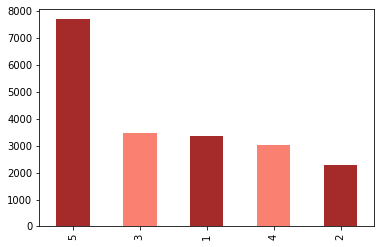

Số lượng phần tử của từng nhãn


In [ ]:
df.star.value_counts().plot(kind="bar", color=["brown", "salmon"])
plt.show()
porc = (len(df[df.star==1]) / len(df.star)) * 100
print('Số lượng phần tử của từng nhãn')

Nhận xét: Tập dữ liệu không cân bằng: Vì có sự chênh lệch lớn giữa nhãn có giá trị là 5 so với các nhãn còn lại.
Kết luận: Gộp nhãn có giá trị 5 và 4 lại là nhãn đánh giá tích cực (nhãn 1). Nhãn có giá trị 1,2 và 3 thành nhãn đánh giá tiêu cực (nhãn 0).




Chuyển đổi nhãn


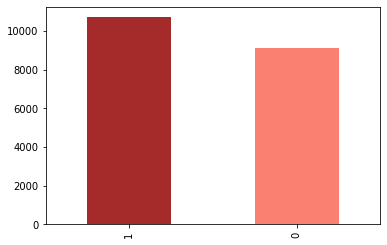

Phần trăm giữa tỉ lệ nhãn 1 và 0: 54.04%


In [ ]:
def change_label(star):
    if star <= 3:
        return 0
    return 1
    
#Chuyển đổi nhãn thành 0: tiêu cực và 1: tích cực
df['label'] = df['star'].apply(change_label)

df.label.value_counts().plot(kind="bar", color=["brown", "salmon"])
plt.show()
porc = (len(df[df.label==1]) / len(df.label)) * 100
print('Phần trăm giữa tỉ lệ nhãn 1 và 0: {:.2f}%'.format(porc))

Nhận xét: Tập dữ liệu phân bố theo: (54:46) hay (6:4) => Tập dữ không quá mất cân bằng, không ảnh hưởng đáng kể tới kết quả dự đoán

URL tham khảo: https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

In [ ]:
def length(text):    
    '''a function which returns the length of text'''
    if(len(text) > 500):
        return 500
    return len(text)

df['length'] = df['content'].apply(length)

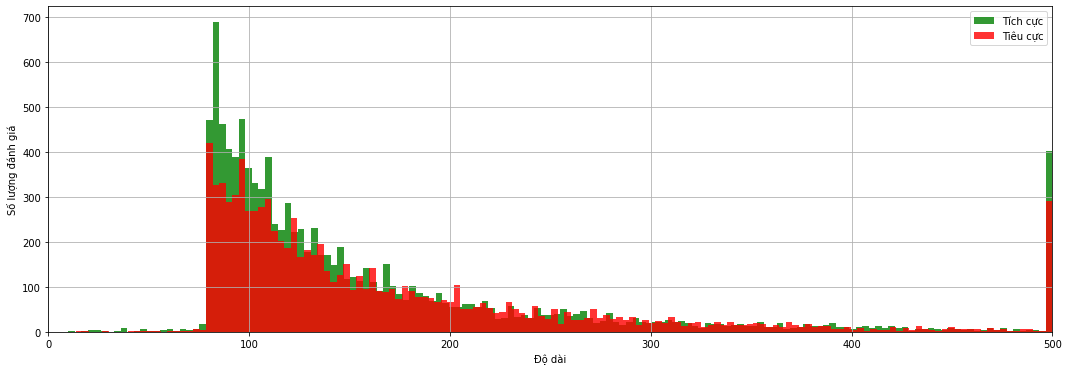

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['label'] == 1]['length'], alpha = 0.8, bins=bins, label='Tích cực', color ="green")
plt.hist(df[df['label'] == 0]['length'], alpha = 0.8, bins=bins, label='Tiêu cực', color ="red")
plt.xlabel('Độ dài')
plt.ylabel('Số lượng đánh giá')
plt.legend(loc='upper right')
plt.xlim(0,500)
plt.grid()
plt.show()

Nhận xét: Trung bình số lượng đánh giá tiêu cực nhiều hơn tích cực có cùng độ dài


#Tiền xử lý

 - Các hàm để phục vụ tiền xử lý

In [ ]:
#Chuẩn hóa unicode sang chuẩn unicode dựng sẵn
def covert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

#Xử lý từ viết tắt
def replace_acronyms(txt):
  pat = re.compile(r"\b(%s)\b" % "|".join(acronyms))
  txt = pat.sub(lambda m: acronyms.get(m.group()), txt)
  return txt

#Xử lý các từ lặp
def remove_loop_char(txt):
  txt = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), str(txt), flags=re.IGNORECASE)
  txt = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',txt)
  return txt

#Xử lý các từ dừng
def remove_stopwords(txt):
  split_words = txt.split()
  final_txt = []
  for ch in split_words:
    if ch not in stopwords:
      final_txt.append(ch)
  return " ".join(final_txt)

#Xử lý dấu câu
def split_punctuations(txt):
    punctuations = '@#!?+&*[]-%:/();$=><|{}^_' + "'`"
    for p in punctuations:
      txt = txt.replace(p, f' {p} ')
    return txt

#Tiền xử lý 
def preProcessing(txt):
  txt = txt.lower()
  #Xóa các kí tự xuống dòng
  txt = " ".join(re.sub("\n", " ", txt).split())
  #Xử lý dấu câu
  txt = split_punctuations(txt)
  #Thay thế các từ viết tắt
  txt = replace_acronyms(txt)
  #Xóa các kí tự lặp
  txt = remove_loop_char(txt)
  #Tách từ
  txt = ViTokenizer.tokenize(txt)
  #Xóa từ dừng
  # txt = remove_stopwords(txt)
  #Chuẩn hóa sang 1 kiểu unicode
  txt = covert_unicode(txt)
  txt = txt.lower()
  # Xóa bớt các khoảng trắng thừa
  return " ".join(txt.split())

In [ ]:
#Tiền xử lý
df['content_clean'] = df['content'].apply(preProcessing)

- Phân chia tập dữ liệu huấn luyện và test bằng nghi thức Hold-out tỉ lệ 7/3

In [ ]:
X, y = df['content_clean'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
type(X_train)

pandas.core.series.Series

Vector hóa văn bảng bằng CountVectorizer và TF-IDF

In [ ]:
#Hàm chuyển dữ liệu train và test thành các vector dùng CountVectorizer và TfidfVectorizer
def count_vector(data_train, data_test):
    count_vectorizer = CountVectorizer(max_features=5000)
    vector_train = count_vectorizer.fit_transform(data_train)
    vector_test = count_vectorizer.transform(data_test)
    return count_vectorizer, vector_train, vector_test

def tfidf_vector(data_train, data_test):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, use_idf=True)
    vector_train = tfidf_vectorizer.fit_transform(data_train)
    vector_test = tfidf_vectorizer.transform(data_test)
    return tfidf_vectorizer, vector_train, vector_test

#Tạo ra vector cho tập train và test với CountVectorizer
count_vector, X_train_Count, X_test_Count = count_vector(X_train, X_test)
#Tạo ra vector cho tập train và test với TfidfVectorizer
tf_idf, X_train_tfidf, X_test_tfidf = tfidf_vector(X_train, X_test)

#Lưu lại model vector hóa

In [ ]:
import pickle

with open("vectorizes.pkl", "wb") as f:
  pickle.dump((count_vector, tf_idf), f)

f.close()

#Xây dựng mô hình
  - Với Naives Bayes Multinomial

In [ ]:
bayes_model_cv = MultinomialNB()
bayes_model_cv.fit(X_train_Count, y_train)
y_bayes_pred = bayes_model_cv.predict(X_test_Count)
print('Độ chính xác với CountVectorizer: %.3f' % accuracy_score(y_test, y_bayes_pred))

bayes_model_tf = MultinomialNB()
bayes_model_tf.fit(X_train_tfidf, y_train)
y_bayes_pred = bayes_model_tf.predict(X_test_tfidf)

print('Độ chính xác với TfidfVectorizer: %.3f' % accuracy_score(y_test, y_bayes_pred))

Độ chính xác với CountVectorizer: 0.834
MultinomialNB()
Độ chính xác với TfidfVectorizer: 0.848


In [ ]:
#Lưu model bayes lại
with open("bayes_model.pkl", "wb") as f:
  pickle.dump((bayes_model_cv, bayes_model_tf), f)

f.close()

- Với SVM

In [ ]:
svm_model_cv = svm.SVC(kernel='linear', C=1.3)
svm_model_cv.fit(X_train_Count, y_train)
y_svm_pred = svm_model_cv.predict(X_test_Count)
print('Độ chính xác với CountVectorizer: %.3f' % accuracy_score(y_test, y_svm_pred))

svm_model_tf = svm.SVC(kernel='linear', C=1.3)
svm_model_tf.fit(X_train_tfidf, y_train)
y_svm_pred = svm_model_tf.predict(X_test_tfidf)
print('Độ chính xác với TfidfVectorizer: %.3f' % accuracy_score(y_test, y_svm_pred))

Độ chính xác với CountVectorizer: 0.828
Độ chính xác với TfidfVectorizer: 0.864


In [ ]:
#Lưu model SVM lại
with open("svm_model.pkl", "wb") as f:
  pickle.dump((svm_model_cv, svm_model_tf), f)

f.close()

- Với Logistic Regression



In [ ]:
linear_model_cv = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
linear_model_cv.fit(X_train_Count, y_train)
y_linear_pred = linear_model_cv.predict(X_test_Count)
print('Độ chính xác với CountVectorizer: %.3f' % accuracy_score(y_test, y_linear_pred))

linear_model_tf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
linear_model_tf.fit(X_train_tfidf, y_train)
y_linear_pred = linear_model_tf.predict(X_test_tfidf)
print('Độ chính xác với TfidfVectorizer: %.3f' % accuracy_score(y_test, y_linear_pred))

Độ chính xác với CountVectorizer: 0.840
Độ chính xác với TfidfVectorizer: 0.865


In [ ]:
#Lưu model logistic lại
with open("linear_model.pkl", "wb") as f:
  pickle.dump((linear_model_cv, linear_model_tf), f)

f.close()

Ta có thể thấy được độ chính xác khi sử dụng TfidfVectorizer luôn cao hơn so với khi sử dụng CountVectorizer. Và mô hình SVM cùng với Logisric Regression cho độ chính xác cao nhất khi đạt đến khoảng 86.5%

# Mô hình DeepLearing - Phobert

Tham khảo từ nguồn https://viblo.asia/p/bert-roberta-phobert-bertweet-ung-dung-state-of-the-art-pre-trained-model-cho-bai-toan-phan-loai-van-ban-4P856PEWZY3

Load từ điển có sẵn của Phobert. Bpe giúp ta enconde(Chuyển 1 câu thành 1 mảng các subword. vocab giúp ánh xạ ngược các subword thành id trong bộ từ điển của Phobert

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)

args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("/content/PhoBERT_base_transformers/dict.txt")

Vì mô hình Phobert có quá trình tiền xử lý khác với các mô hình thông thường nên ta cần tiền xử lý khác đi 1 chút

In [ ]:
def remove_emoji(txt):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r" ", txt)

def fix_number(txt):
    txt = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', txt)
    return txt

def preProcessing(txt):
    txt = txt.lower()
    txt = txt.replace('\n',' ')
    txt = txt.replace(':)',' ')
    txt = txt.replace(':))',' ')
    txt = txt.replace(':)))',' ')
    txt = txt.replace('=)',' ')
    txt = txt.replace('=))',' ')
    txt = txt.replace('=)))',' ')
    txt = txt.replace(':(',' ')
    txt = txt.replace(':((',' ')
    txt = txt.replace(':(((',' ')
    txt = txt.replace('...',' . ')
    txt = split_punctuations(txt)
    txt = fix_number(txt)
    #Thay thế các từ viết tắt
    txt = replace_acronyms(txt)
    txt = remove_emoji(txt)
    txt = ViTokenizer.tokenize(txt)
    txt = txt.lower()
    return txt

df['clean_content'] = df['content'].apply(preProcessing)

Tiến hành phân chia tập dữ liệu bằng Hold-out và bắt đầu encode. Với MAX_LEN = 84 có nghĩa là các câu có độ dài lớn hơn sẽ bị cắt còn 124 từ

In [ ]:
MAX_LEN = 84

X = df['clean_content']
y = df['label'].to_list()

train_sents, val_sents, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state = 42)

#Tiến hành encode
train_ids = []
val_ids = []

for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

for sent in val_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    val_ids.append(encoded_sent)

#List các id
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

Ta tiến hành tạo các mask là mảng gồm các số 0 1 nhằm kiểm tra xem các giá trị nào của chuỗi đã được padding

In [ ]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

val_masks = []
for sent in val_ids:
    mask = [int(token_id > 0) for token_id in sent]

    val_masks.append(mask)

Chuyển dữ liệu sang Tensor và sử dụng DataLoader của torch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
BATCH_SIZE = 12

train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

Ta tiến hành load mô hình từ Phobert (Mô hình này chưa qua huấn luyện với tập dữ liệu hiện tại)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW, BertForSequenceClassification

config = RobertaConfig.from_pretrained(
    "/content/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 2, output_hidden_states=False,
)
BERT_SA = BertForSequenceClassification.from_pretrained(
    "/content/PhoBERT_base_transformers/model.bin", 
    config=config
)

BERT_SA.cuda()

Hoặc ta có thể load mô hình Phobert mà đã qua huấn luyện với tập dữ liệu hiện tại

In [ ]:
#Chỉnh đường dẫn lại theo file đi kèm
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW, BertForSequenceClassification

config = RobertaConfig.from_pretrained(
    "/content/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 2, output_hidden_states=False,
)
BERT_SA = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/model_phobert/pytorch_model.bin",
    config=config
)

BERT_SA.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, element

Hàm để huấn luyện 

In [ ]:
def flat_accuracy(logits, labels):
    preds = []
    for line in logits:
        preds.append(torch.argmax(line).cpu().numpy())
    return accuracy_score(preds, labels.cpu().numpy())

In [ ]:
def train_model(model):
    model.train()
    train_loss = 0
    acc = []
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        BERT_SA.zero_grad()
        outputs = model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        acc.append(flat_accuracy(logits, b_labels))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()

    return train_loss, round(np.mean(acc), 3)

Tiến hành huấn luyện mô hình. Nếu ta load mô hình đã qua huấn luyện thì có thể bỏ qua đoạn này

In [ ]:
from tqdm.notebook import tqdm
import time
device = 'cuda'
epochs = 4

param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(BERT_SA.parameters(), lr=1e-5, correct_bias=False)
train_loss_ = []
test_loss_ = []

for epoch in range(epochs):
    begin_time = time.time()
    loss, acc = train_model(BERT_SA)
    done_time = time.time() - begin_time
    print(f"Epoch {epoch + 1}: {round(done_time)} seconds - loss {round(loss, 3)} - accuracy {acc}")
    train_loss_.append([loss, acc])

Tiến hành dự đoán trên tập test. Kết quả trả về sẽ là 1 mảng [a, b] trong đó a và b là xác xuất của dữ liệu đó đối với nhãn 0 và 1

In [ ]:
device = 'cuda'
preds = []
for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():
        pred=BERT_SA(b_input_ids,token_type_ids=None,attention_mask=b_input_mask)
        preds.append(pred[0])

Dùng hàm argmax của numpy để chuyển đổi mảng [a,b] thành nhãn 0 hay là 1. 

In [ ]:
lab = []
for line in preds:
  for i in line:
    predicts = i.to('cuda').detach().numpy().copy()
    lab.append(np.argmax(predicts))

Đánh giá mô hình 

In [ ]:
print(accuracy_score(val_labels.tolist(), lab))

0.8453192026242745


Đoạn code này sẽ xóa mô hình để tránh việc bị lỗi. Nên chạy đoạn code này sau khi đã tạo mô hình trên Colab hoặc Kaggle tránh việc gây lỗi 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
del BERT_SA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
